In [1]:
import os
import numpy as np
import pandas as pd
from scipy import ndimage

from upapy.reconstruction.ubp2d import FastUBP
from upapy.io import load_data

In [2]:
df = pd.read_excel('mouse_data.xlsx')
df = df[df['train_or_test'].isin(['train', 'test'])]
df

,file_name,description,train_or_test,frame_recom,best_sos,pos1,pos2,pos3,pos4,pos5
0,20240606140047_Spectrum_mouse_w2_690-750_pos15...,皮下血管清晰,train,0:49:5,1474.0,NaN,NaN,NaN,NaN,NaN
1,20240606153406_Spectrum_mouse_w3_690-750-5-pos...,皮下血管一般,train,0:49:5,1476.0,NaN,NaN,NaN,NaN,NaN
2,20240606154106_Spectrum_mouse_w3_690-750-5-pos...,皮下血管清晰,train,0:49:5,1473.0,NaN,NaN,NaN,NaN,NaN
3,20240606154315_Spectrum_mouse_w3_690-750-5-pos...,皮下血管清晰，与20240606154106相似,test,0:49:5,1474.0,NaN,NaN,NaN,NaN,NaN
4,20240606154520_Spectrum_mouse_w3_690-750-5-pos...,皮下血管一般，与20240606153406相似,test,0:49:5,1476.0,NaN,NaN,NaN,NaN,NaN
5,20250212134032_mouse_1064_30_15db.pah5,皮下血管一般，体位不正,train,0:299:5,1506.0,NaN,NaN,NaN,NaN,NaN
6,D304_1064+nm_30+%_20db_mouse_000.upa,皮下血管较差,train,0:199:5,1497.0,NaN,NaN,NaN,NaN,NaN
8,D1952_720 nm_%_45db_720_70%_23-33_PROBE_JING.pah5,皮下血管清晰,test,0:199:5,1473.0,NaN,NaN,NaN,NaN,NaN
10,D2503_1064 nm_30 %_15db_mouse_pos6_f100.pah5,皮下血管一般，左右侧声速差5ms,train,0:99:10,1478.0,NaN,NaN,NaN,NaN,NaN
12,D2657_900 nm_94.349998_20db_mouse_000.pah5,皮下血管清晰,test,0:99:5,1474.0,NaN,NaN,NaN,NaN,NaN


In [3]:
def max_pooling(img, pool_size=3):
    """最大池化"""
    maximum_filter = ndimage.maximum_filter(img, size=(1, pool_size, pool_size))
    return maximum_filter[:, ::pool_size, ::pool_size]

In [4]:
file_dir = '../data'
min_sos, max_sos, sos_step = 1450, 1550, 5

for file_name in df['file_name']:
    # 读取原始文件
    full_path = os.path.join(file_dir, 'mouse_data', file_name)
    data = load_data(full_path)
    print('开始处理：', full_path)
    print('原始数据:', data.shape)

    # 重构前的准备工作
    ubp = FastUBP()
    ubp.set_pa_frame_element_number(data.shape[1])

    sos_list = np.arange(min_sos, max_sos, sos_step) / 1000.0
    frame_recom = df.loc[df['file_name'] == file_name, 'frame_recom'].tolist()
    start, stop, step = map(int, frame_recom[0].split(':'))

    # 开始重构
    images_list = []
    for i in range(start, stop, step):
        img_list = []
        for sos in sos_list:
            ubp.set_reconstruction_water_sos(sos)
            img_list.append(ubp.reconstruction(data[i]))
        images_list.append(np.array(img_list))
    images_array = np.array(images_list)
    print('重构图像:', images_array.shape)

    # 3*3最大池化
    images_maxpool = []
    for i in range(images_array.shape[0]):
        images_maxpool.append(max_pooling(images_array[i]))
    images_maxpool = np.array(images_maxpool)
    print('池化图像:', images_maxpool.shape)

    # 打标签
    best_sos = df.loc[df['file_name'] == file_name, 'best_sos'].tolist()
    labels = ((sos_list * 1000) > best_sos[0]).astype(int)
    labels = np.tile(labels, images_array.shape[0])

    save_dict = {
        'images': images_maxpool.reshape(-1, 250, 250),
        'labels': labels,
    }

    save_name = file_name.split('_', 1)[0] + '.npy'
    save_path = os.path.join(file_dir, 'data_1450_1550_5ms', save_name)
    np.save(save_path, save_dict)
    print('已保存至:', save_path)
    print("=" * 80)

开始处理： ../data\mouse_data\20240606140047_Spectrum_mouse_w2_690-750_pos15.pah5
原始数据: (53, 512, 2000)
重构图像: (10, 20, 750, 750)
池化图像: (10, 20, 250, 250)
已保存至: ../data\data_1450_1550_5ms\20240606140047.npy
开始处理： ../data\mouse_data\20240606153406_Spectrum_mouse_w3_690-750-5-pos25.pah5
原始数据: (53, 512, 2000)
重构图像: (10, 20, 750, 750)
池化图像: (10, 20, 250, 250)
已保存至: ../data\data_1450_1550_5ms\20240606153406.npy
开始处理： ../data\mouse_data\20240606154106_Spectrum_mouse_w3_690-750-5-pos20.pah5
原始数据: (53, 512, 2000)
重构图像: (10, 20, 750, 750)
池化图像: (10, 20, 250, 250)
已保存至: ../data\data_1450_1550_5ms\20240606154106.npy
开始处理： ../data\mouse_data\20240606154315_Spectrum_mouse_w3_690-750-5-pos22.pah5
原始数据: (53, 512, 2000)
重构图像: (10, 20, 750, 750)
池化图像: (10, 20, 250, 250)
已保存至: ../data\data_1450_1550_5ms\20240606154315.npy
开始处理： ../data\mouse_data\20240606154520_Spectrum_mouse_w3_690-750-5-pos27.pah5
原始数据: (53, 512, 2000)
重构图像: (10, 20, 750, 750)
池化图像: (10, 20, 250, 250)
已保存至: ../data\data_1450_1550_5ms\202406

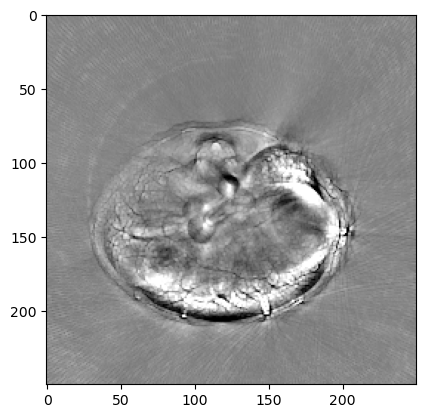

0


In [5]:
# 测试
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(save_dict['images']))
plt.imshow(save_dict['images'][idx], cmap='gray', vmin=-10, vmax=10)
plt.show()
print(save_dict['labels'][idx])

In [6]:
# save_dict = np.load(save_path, allow_pickle=True).item()
# images = save_dict['images']
# labels = save_dict['labels']
#
# dataset = list(zip(images, labels))
# dataset[0]